In [1]:
import os
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
net1 = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10))
net1

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)

In [3]:
net2 = nn.Sequential(collections.OrderedDict([
    ('fc1', nn.Linear(784, 256)),
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(256, 10))
]))
net2

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [4]:
a = torch.rand(4, 784)
out1 = net1(a)
out2 = net2(a)
out1.shape == out2.shape, out1.shape

(True, torch.Size([4, 10]))

In [5]:
net3 = nn.ModuleList([nn.Linear(784, 256), nn.ReLU()])
net3.append(nn.Linear(256, 10))
print(net3[-1])
net3

Linear(in_features=256, out_features=10, bias=True)


ModuleList(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=10, bias=True)
)

In [6]:
net3(a) #没有定义一个网络，只是将不同模块储存在一起

NotImplementedError: Module [ModuleList] is missing the required "forward" function

In [7]:
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.modulelist = nn.ModuleList([nn.Linear(784, 256), nn.ReLU()])
        self.modulelist.append(nn.Linear(256, 10))
    def forward(self, x):
        for layer in self.modulelist:
            x = layer(x)
        return x
net3_ = Net3()
out3_ = net3_(a)
out3_

tensor([[-0.1256, -0.0162, -0.2567, -0.0291,  0.1629,  0.0358, -0.1742, -0.0541,
          0.1035, -0.1768],
        [-0.1381,  0.0104, -0.1989, -0.0224,  0.0556,  0.0634, -0.2107, -0.0284,
          0.1622, -0.1938],
        [-0.1248, -0.0754, -0.3102, -0.0173, -0.0193,  0.1253, -0.1721,  0.0143,
          0.0087, -0.2099],
        [-0.1559, -0.0307, -0.2791, -0.1015,  0.0086,  0.0551, -0.1893,  0.0200,
          0.1209, -0.1634]], grad_fn=<AddmmBackward0>)

In [8]:
net4 = nn.ModuleDict({ #同样缺少前向传播模块
    'linear':nn.Linear(784, 256),
    'act':nn.ReLU()
})
net4['output'] = nn.Linear(256, 10)
net4['linear'], net4.output

(Linear(in_features=784, out_features=256, bias=True),
 Linear(in_features=256, out_features=10, bias=True))

In [9]:
net4(a)

NotImplementedError: Module [ModuleDict] is missing the required "forward" function

In [10]:
class Net4(nn.Module):
    def __init__(self):
        super().__init__()
        self.moduledict = nn.ModuleDict({
            'lin':nn.Linear(784, 256),
            'act':nn.ReLU(),
        })
        self.moduledict['output'] = nn.Linear(256, 10)
    def forward(self, x):
        for _, key in self.moduledict.items():
            x = key(x)
        return x
net4_ = Net4()
net4_, net4_(a)

(Net4(
   (moduledict): ModuleDict(
     (lin): Linear(in_features=784, out_features=256, bias=True)
     (act): ReLU()
     (output): Linear(in_features=256, out_features=10, bias=True)
   )
 ),
 tensor([[ 0.0929, -0.1111, -0.0046, -0.1728,  0.1909,  0.1654,  0.0125,  0.0614,
           0.1932, -0.0345],
         [ 0.2227, -0.0579, -0.0221, -0.1926,  0.2690,  0.0920, -0.1214,  0.1260,
           0.0619,  0.0285],
         [ 0.1912, -0.0654, -0.0131, -0.1759,  0.2255,  0.1172, -0.0766,  0.1277,
           0.0879, -0.0567],
         [ 0.1933, -0.0385, -0.1013, -0.1648,  0.2431,  0.1466,  0.1026,  0.1235,
           0.1547, -0.0030]], grad_fn=<AddmmBackward0>))

# 搭建Unet网络

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)

In [3]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )
    def forward(self, x):
        return self.maxpool_conv(x)

In [4]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                       diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [5]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        return self.conv(x)

In [6]:
## 组装
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)
        self.up3 = Up(256, 128//factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [11]:
unet = UNet(3, 1)
unet

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

# 模型修改

In [23]:
import copy
unet1 = copy.deepcopy(unet)
unet1.outc

OutConv(
  (conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [25]:
b = torch.rand(1,3,256,256)
out_net1 = unet1(b)
out_net1.shape

torch.Size([1, 1, 256, 256])

In [26]:
unet1.outc = OutConv(64, 5)
unet1.outc

OutConv(
  (conv): Conv2d(64, 5, kernel_size=(1, 1), stride=(1, 1))
)

In [27]:
unet1['outc'] = OutConv(64, 4) # 模型不支持字典对操作
unet1.outc

TypeError: 'UNet' object does not support item assignment

In [28]:
unet1(b).shape

torch.Size([1, 5, 256, 256])

In [29]:
# 添加额外输入
class UNet2(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet2, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        
    def forward(self, x, add_variable):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = x + add_variable # 修改点
        logits = self.outc(x)
        return logits

In [31]:
b.shape

torch.Size([1, 3, 256, 256])

In [33]:
c = torch.randn(1, 1, 256, 256)
unet2 = UNet2(3, 1)

unet2(b, c).shape

torch.Size([1, 1, 256, 256])

In [37]:
unet2_test = UNet2(3, 1, bilinear=False) # 使用反卷积操作
unet2_test(b, c).shape

torch.Size([1, 1, 256, 256])

In [47]:
# 添加额外输出
class UNet3(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet3, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor) # 如果bilinear为FASLE,upsample处理通道数不变,
        #upsmaple输入的通道数要为convtranspose2d的1/2,所以要进行除二操作
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4) #x5和x4在同一层
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits, x5 # 修改点

unet3 = UNet3(3, 1)
out_unet3 , out_mid = unet3(b)
out_unet3.shape, out_mid.shape

(torch.Size([1, 1, 256, 256]), torch.Size([1, 512, 16, 16]))

In [50]:
# 模型的保存和读取
unet.state_dict()

OrderedDict([('inc.double_conv.0.weight',
              tensor([[[[-0.0210, -0.0183, -0.1124],
                        [-0.1179, -0.0373,  0.0914],
                        [-0.0421,  0.1425,  0.0274]],
              
                       [[-0.0687,  0.0255,  0.1131],
                        [-0.1738,  0.0340,  0.0287],
                        [-0.0270,  0.0571, -0.0310]],
              
                       [[ 0.0776, -0.1705,  0.0395],
                        [ 0.0951, -0.0923,  0.1871],
                        [ 0.0444, -0.0531,  0.1363]]],
              
              
                      [[[ 0.1756,  0.1317,  0.0908],
                        [-0.1682, -0.0826, -0.0691],
                        [-0.0212,  0.0212,  0.0090]],
              
                       [[ 0.0978,  0.0475, -0.1635],
                        [ 0.1388,  0.0998, -0.0557],
                        [-0.1715, -0.0666, -0.0120]],
              
                       [[-0.0944,  0.0193,  0.0962],
              

In [51]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
unet_mul = copy.deepcopy(unet)
unet_mul = nn.DataParallel(unet_mul).cuda()
unet_mul

DataParallel(
  (module): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, 

In [52]:
torch.save(unet_mul, './unet_mul_example.pth')

In [53]:
loaded_unet_mul = torch.load('./unet_mul_example.pth')
loaded_unet_mul

DataParallel(
  (module): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, 

In [58]:
## 多卡：保存&读取模型权重
torch.save(unet_mul.state_dict(), './unet_weight_mul_example.pth')

In [59]:
loaded_unet_weights_mul = torch.load('./unet_weight_mul_example.pth')
unet_mul.load_state_dict(loaded_unet_weights_mul)
unet_mul = nn.DataParallel(unet_mul).cuda()
unet_mul.state_dict()

OrderedDict([('module.module.inc.double_conv.0.weight',
              tensor([[[[-0.0210, -0.0183, -0.1124],
                        [-0.1179, -0.0373,  0.0914],
                        [-0.0421,  0.1425,  0.0274]],
              
                       [[-0.0687,  0.0255,  0.1131],
                        [-0.1738,  0.0340,  0.0287],
                        [-0.0270,  0.0571, -0.0310]],
              
                       [[ 0.0776, -0.1705,  0.0395],
                        [ 0.0951, -0.0923,  0.1871],
                        [ 0.0444, -0.0531,  0.1363]]],
              
              
                      [[[ 0.1756,  0.1317,  0.0908],
                        [-0.1682, -0.0826, -0.0691],
                        [-0.0212,  0.0212,  0.0090]],
              
                       [[ 0.0978,  0.0475, -0.1635],
                        [ 0.1388,  0.0998, -0.0557],
                        [-0.1715, -0.0666, -0.0120]],
              
                       [[-0.0944,  0.0193,  0.0962],


# 优雅地训练pytorch模型
**使用Carvana数据集，实现一个基本的UNet训练过程**

In [7]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import PIL
from sklearn.model_selection import train_test_split

In [8]:
class CarvanaDataset(Dataset):
    def __init__(self, base_dir, idx_list, mode='train', transform=None):
        self.base_dir = base_dir
        self.idx_list = idx_list
        self.images = os.listdir(base_dir+'train') # trian中图片名
        self.masks = os.listdir(base_dir+'train_masks')
        self.mode = mode
        self.transform = transform
    
    def __len__(self):
        return len(self.idx_list)
    
    def __getitem__(self, index):
        image_file = self.images[self.idx_list[index]] #某一个图片名
        mask_file = image_file[:-4] +'_mask.gif' # 新的文件名
        image = PIL.Image.open(os.path.join(base_dir, 'train', image_file))
        if self.mode == 'train':
            mask = PIL.Image.open(os.path.join(base_dir, 'train_masks', mask_file))
            if self.transform is not None:
                image = self.transform(image)
                mask = self.transform(mask)
                mask[mask!=0] = 1.0
            return image, mask.float()
        else:
            if self.transform is not None:
                iamge = self.transform(image)
            return image
base_dir = './'
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
train_idxs, val_idxs = train_test_split(range(len(os.listdir(base_dir+'train_masks'))), test_size=0.3)
train_data = CarvanaDataset(base_dir, train_idxs, transform=transform)
val_data = CarvanaDataset(base_dir, val_idxs, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

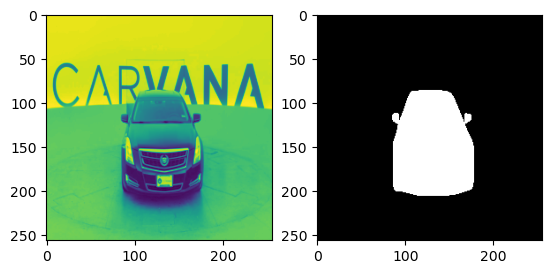

In [9]:
image, mask = next(iter(train_loader))
plt.subplot(121)
plt.imshow(image[0,0])
plt.subplot(122)
plt.imshow(mask[0, 0], cmap='gray')

In [12]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-3, weight_decay=1e-8)

unet = nn.DataParallel(unet).cuda()

In [13]:
def dice_coeff(pred, target):
    eps = 1e-4
    num = pred.size(0)
    m1 = pred.view(num, -1)
    m2 = target.view(num, -1)
    intersection = (m1 * m2).sum()
    return (2. * intersection + eps) / (m1.sum() + m2.sum() + eps)
def train(epoch):
    unet.train()
    train_loss = 0
    for data, mask in train_loader:
        data, mask = data.cuda(), mask.cuda()
        optimizer.zero_grad()
        output = unet(data)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    print('Epoch:{} \tTraining Loss:{:.6f}'.format(epoch, train_loss))

def val(epoch):
    print('current learning rate: ', optimizer.state_dict)
    unet.eval()
    val_loss = 0
    dice_score = 0
    with torch.no_grad():
        for data, mask in val_loader:
            data, mask = data.cuda(), mask.cuda()
            output = unet(data)
            loss = criterion(output, mask)
            val_loss += loss.item()*data.size(0)
            dice_score += dice_coeff(torch.sigmoid(output).cpu(), mask.cpu())*data.size(0)
    val_loss = val_loss/len(val_loader.dataset)
    dice_score = dice_score/len(val_loader.dataset)
    print('Epoch:{} \tValidation Loss:{:.6f}, Dice Score:{:.6f}'.format(epoch, val_loss, dice_score))

In [75]:
epochs = 100 # 花费时间太长了
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

Epoch:1 	Training Loss:0.132278
current learning rate:  <bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 1e-08
)>


AttributeError: module 'torch' has no attribute 'sigmoidz'

In [76]:
!nvidia-smi

Tue Nov 22 12:37:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.36       Driver Version: 512.36       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   35C    P8    10W /  N/A |  16175MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

'kill' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [77]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
        
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum() # 对位相乘再求和
        dice = (2.*intersection +smooth)/(inputs.sum() + targets.sum() + smooth)
        return 1-dice

In [79]:
newcriterion = DiceLoss()

unet.eval()
image, mask = next(iter(val_loader))
out_unet = unet(image.cuda())
loss = newcriterion(out_unet, mask.cuda())
print(loss)

tensor(0.1251, device='cuda:0', grad_fn=<RsubBackward1>)


In [14]:
# 动态调整学习率,训练时间太长了
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
epochs = 100
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)
    scheduler.step()

Epoch:1 	Training Loss:0.148289
current learning rate:  <bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 1e-08
)>
Epoch:1 	Validation Loss:0.052869, Dice Score:0.902705
Epoch:2 	Training Loss:0.038381
current learning rate:  <bound method Optimizer.state_dict of Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    initial_lr: 0.001
    lr: 0.0008
    maximize: False
    weight_decay: 1e-08
)>


KeyboardInterrupt: 

In [15]:
# 模型微调
unet.module.outc.conv.weight.requires_grad = False
unet.module.outc.conv.bias.requires_grad = False
for layer, param in unet.named_parameters():
    print(layer, '\t', param.requires_grad)

module.inc.double_conv.0.weight 	 True
module.inc.double_conv.1.weight 	 True
module.inc.double_conv.1.bias 	 True
module.inc.double_conv.3.weight 	 True
module.inc.double_conv.4.weight 	 True
module.inc.double_conv.4.bias 	 True
module.down1.maxpool_conv.1.double_conv.0.weight 	 True
module.down1.maxpool_conv.1.double_conv.1.weight 	 True
module.down1.maxpool_conv.1.double_conv.1.bias 	 True
module.down1.maxpool_conv.1.double_conv.3.weight 	 True
module.down1.maxpool_conv.1.double_conv.4.weight 	 True
module.down1.maxpool_conv.1.double_conv.4.bias 	 True
module.down2.maxpool_conv.1.double_conv.0.weight 	 True
module.down2.maxpool_conv.1.double_conv.1.weight 	 True
module.down2.maxpool_conv.1.double_conv.1.bias 	 True
module.down2.maxpool_conv.1.double_conv.3.weight 	 True
module.down2.maxpool_conv.1.double_conv.4.weight 	 True
module.down2.maxpool_conv.1.double_conv.4.bias 	 True
module.down3.maxpool_conv.1.double_conv.0.weight 	 True
module.down3.maxpool_conv.1.double_conv.1.weight 	

In [16]:
param

Parameter containing:
tensor([0.0096], device='cuda:0')

In [ ]:
# 半精度训练
from torch.cuda.amp import autocast

# 在unet模块里 的forward函数上添加修饰器 @autocast()就可以了